In [1]:
library(data.table)
library(ggplot2)
theme_set(theme_bw())

In [2]:
setwd('~/m/bacterial_dating/19_coherent_prediction_workflow')

In [3]:
# Read cv probabities
system('ls data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.csv.cv_data/*csv > data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.csv.cv_data/files.txt')
files = fread('data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.csv.cv_data/files.txt', header=F)
d1 = files[grep('Perceptron', invert = T, V1),fread(input=V1, header=T, sep='\t', colClasses=list(double='y_actual')), by=V1]
d2 = files[grep('Perceptron', V1),fread(input=V1, header=T, sep='\t', colClasses=list(double=c('y_actual','false_negative_rate','false_positive_rate'))), by=V1]
d2[, prob_anaerobe := -1]
d2[, prob_aerobe := -1]
d = rbind(d1, d2)
d[1:3]

V1,prob_anaerobe,prob_aerobe,prediction,accession,y_actual,false_negative_rate,false_positive_rate,predictor
<chr>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.csv.cv_data/prediction_probabilities_AdaBoostClassifier_0.csv,0.5677817,0.4322183,0,GB_GCA_000010565.1,0,0,0.0,AdaBoostClassifier
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.csv.cv_data/prediction_probabilities_AdaBoostClassifier_0.csv,0.5689089,0.4310911,0,GB_GCA_000010565.1,0,0,0.1,AdaBoostClassifier
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.csv.cv_data/prediction_probabilities_AdaBoostClassifier_0.csv,0.5748905,0.4251095,0,GB_GCA_000010565.1,0,0,0.2,AdaBoostClassifier


In [4]:
d[, V1 := NULL]

In [5]:
# d[, y_actual:=1]

In [6]:
accuracies = d[,.(
    tp = sum(prediction==1 & y_actual==1),
    tn = sum(prediction==0 & y_actual==0),
    fp = sum(prediction==1 & y_actual==0),
    fn = sum(prediction==0 & y_actual==1)
), by=list(predictor, false_negative_rate, false_positive_rate)]
accuracies[, accuracy := (tp+tn)/(tp+tn+fp+fn)]
accuracies[1:3]

predictor,false_negative_rate,false_positive_rate,tp,tn,fp,fn,accuracy
<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
AdaBoostClassifier,0,0.0,1974,748,67,74,0.9507510
AdaBoostClassifier,0,0.1,1967,738,77,81,0.9448131
AdaBoostClassifier,0,0.2,1961,731,84,87,0.9402724


# Plot accuracy with increasing removal of gene families (false negative rate)

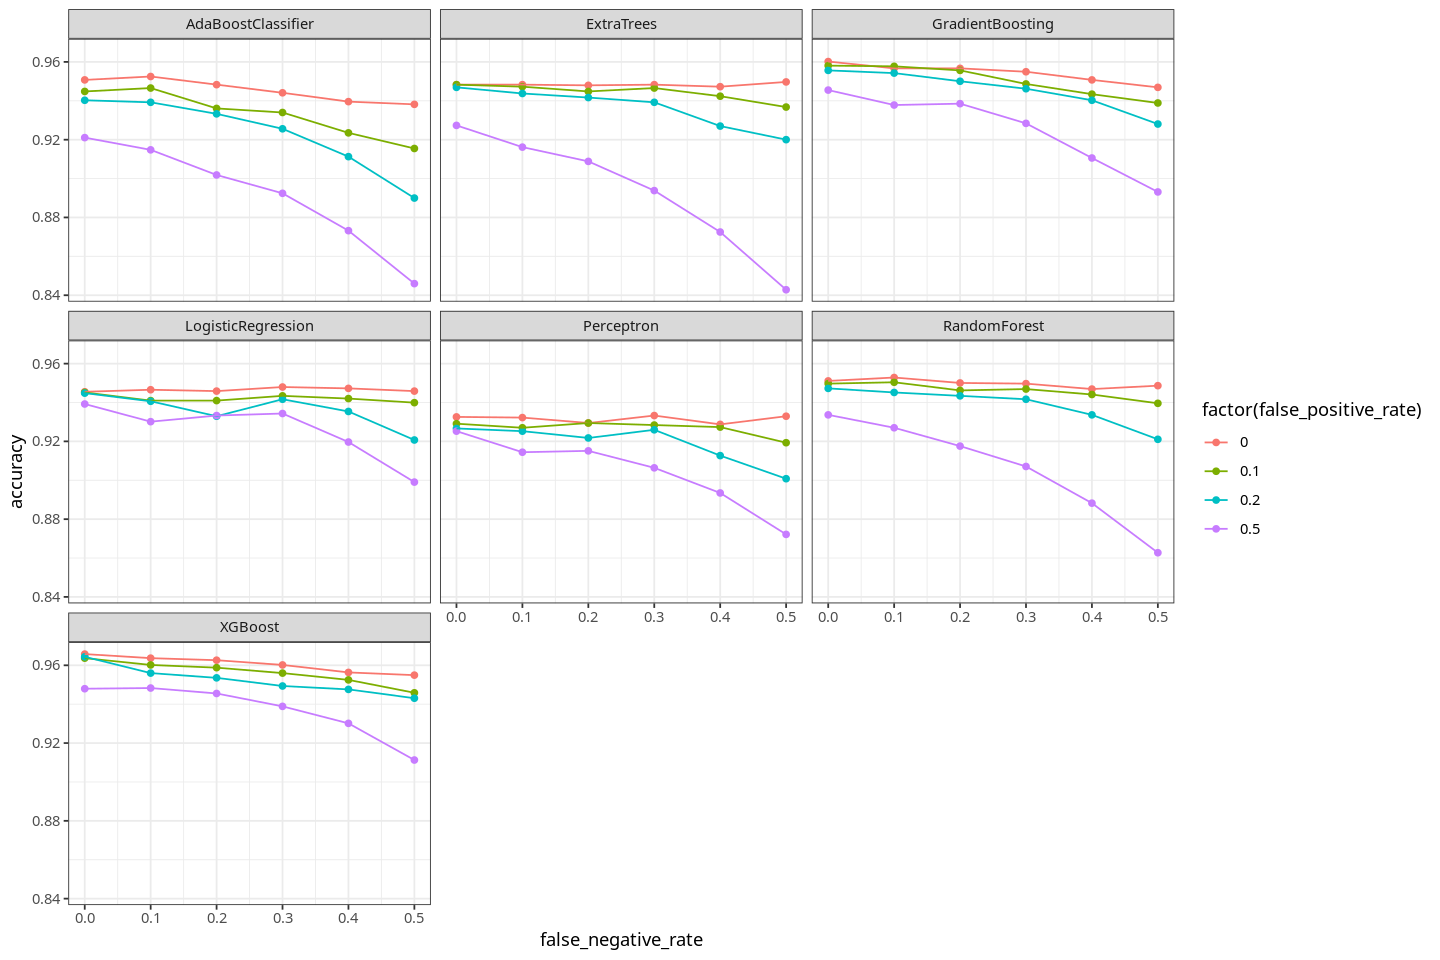

In [7]:
options(repr.plot.width=12, repr.plot.height=8)
qplot(data=accuracies[grep('Isotonic',predictor,invert=T)][grep('Sigmoid',predictor,invert=T)][grep('GaussianNB',predictor,invert=T)][false_positive_rate %in% c(0,0.1,0.2,0.5)], false_negative_rate, accuracy, colour=factor(false_positive_rate))+geom_line()+facet_wrap(~predictor)

# Prediction probabilities change with calibration? TODO

In [8]:
d[false_positive_rate==0 & false_negative_rate==0][grep('XGBoost',predictor), .(accession,predictor, prob_aerobe)][accession=='GB_GCA_000252485.1']

accession,predictor,prob_aerobe
<chr>,<chr>,<dbl>
GB_GCA_000252485.1,XGBoost,0.9999049


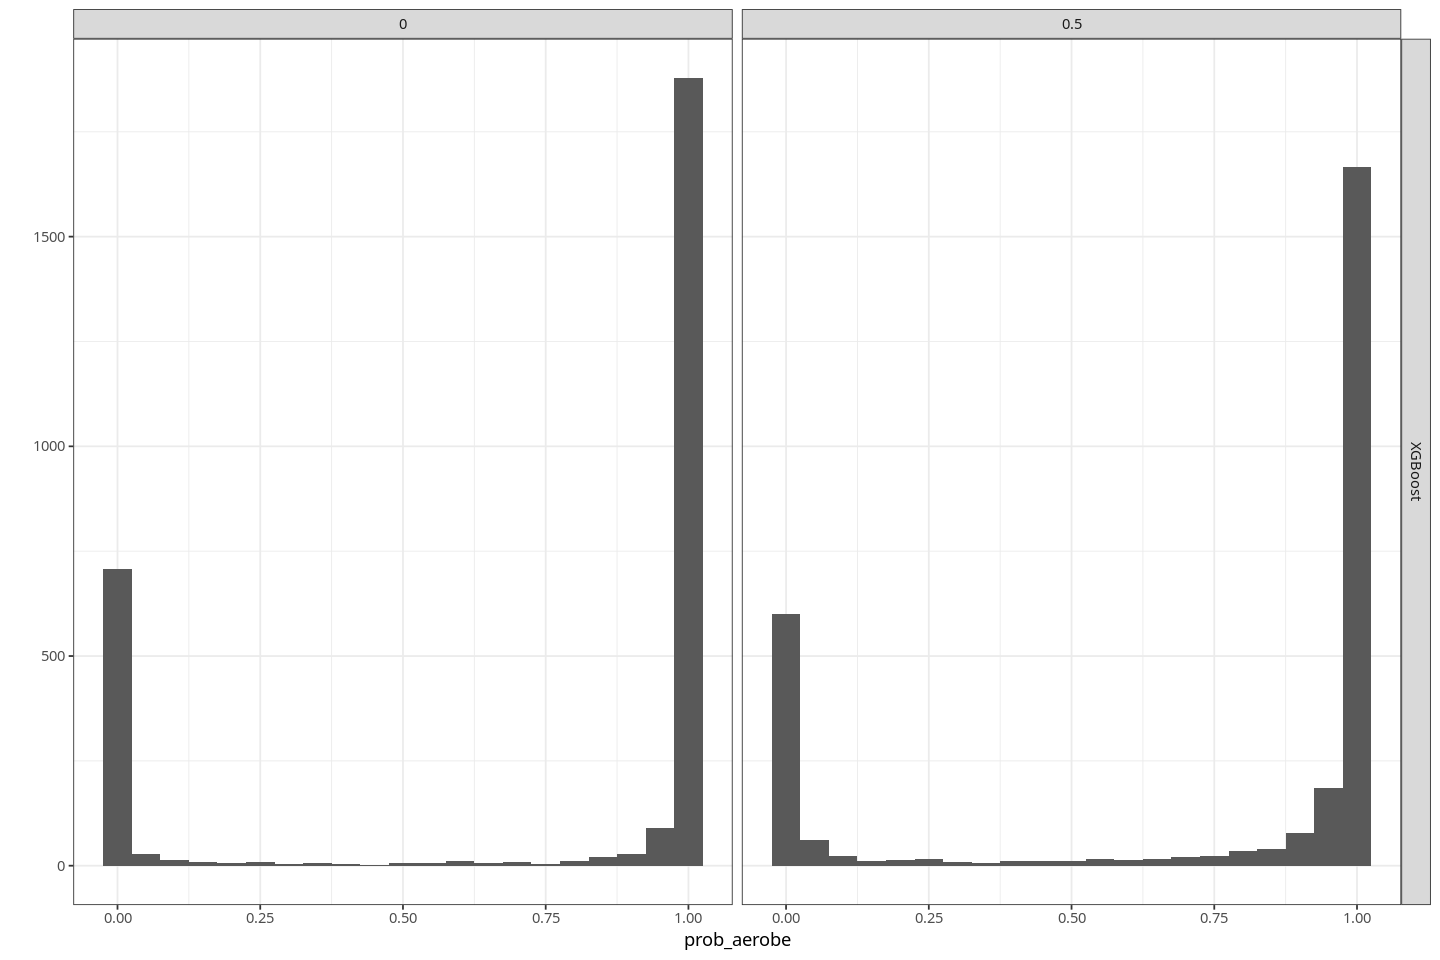

In [9]:
qplot(data=d[grep('XGBoost',predictor)][false_positive_rate %in% c(0) & false_negative_rate %in% c(0,0.5)], prob_aerobe, geom='histogram', binwidth=0.05, )+facet_grid(predictor~false_negative_rate)

In [10]:
m = dcast(d[false_positive_rate==0 & false_negative_rate==0.5][grep('XGBoost',predictor), .(accession,predictor, prob_aerobe)], accession~predictor, value.var='prob_aerobe')
m[1:3]
qplot(data=m, XGBoost, XGBoost_Isotonic, alpha=I(1/10))

accession,XGBoost
<chr>,<dbl>
GB_GCA_000010565.1,0.0001291322
GB_GCA_000018565.1,0.9972490700
GB_GCA_000145985.1,0.0072474570


ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'XGBoost_Isotonic' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capture.out